# Impact of learning rate on neutral network performance
The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. 

1. Learning Rate and Gradient Descent
2. Configure the Learning Rate in Keras
3. Multi-Class Classification Problem
4. Effect of Learning Rate and Momentum
5. Effect of Learning Rate Schedules
6. Effect of Adaptive Learning Rates

# 1. learning rate and gradient descent
- Gradient Descent is an algorithm that estimates the error gradient for the current state of the model using training dataset, then update weight of the model. The amount that the weight is updated during training is referred to as the step size or learning rate.

- Specifically, the learning rate is a configurable hyperparameter used in the training of neural networks that has a small positive value, often in the range between 0.0 and 1.0.

# 2. Configure the learning rate in Keras
## 2.1 Stochastic Gradient Descent (SGD)

In [1]:
# from keras.optimizers import SGD

# # create default sgd, lr=0.01, no mementum
# opt = SGD()
# #model.compile(..., optimizer=opt)

# # customize lr, momentum arguments
# opt = SGD(lr=0.01, momentum=0.9)

# # using learning rate decay with decay argument for each update learning rate
# opt = SGD(lr=0.01, momentum=0.9, decay=0.01)

## 2.2 Learning rate schedule
- specified configuration in the callbacks arg of the fit function when train model.
- The Keras provides ReduceLROnPlateau() to adjust the learning rate when a plateau in the model performance is detected, e.g. no more change for given number of training epochs. This callbacks arg is designed to reduce the learning rate after the model stops improving. 

In [2]:
# from keras.callbacks import ReduceLROnPlateau

# rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)
# #model.fit(..., callbacks=[rlrop])

In [3]:
# # customize Learning rate schedule callback
# from keras.callbacks import LearningRateScheduler

# def my_learning_rate(epoch, lrate):
#     return lrate

# lrs = LearningRateScheduler(my_learning_rate)
# #model.fit(..., callbacks=[lrs])

## 2.3 Adative Learning rate Gradient Descent

- Keras provides three common Adaptive Learning Rate methods

from keras.optimizers import RMSprop, Adagrad, Adam

opt = RMSprop()

# 3. Multi-class classification Problem
- representation effect of learning rate on model performance.
- 2 input variables (x, y) and the standard deviation of 2.0 for points within each group, use the same random state (seed of generation number) to ensure that we always get the same data points.

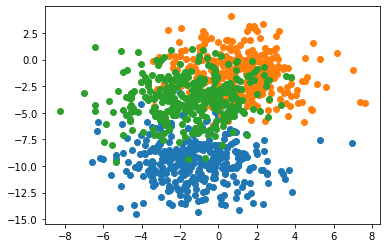

In [3]:
## Generate data points
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from numpy import where

# Generate 2d dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# Scatter plot for each class value
for class_value in range(3):
    row_ix = where(y == class_value)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
plt.show()

In [3]:
# to disable, ignore warning from tensorflow
import os
from keras.layers import Dense
from keras.models import Sequential
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

# prepare dataset
def prepare_data():
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
    # one hot encode output variable
    y = keras.utils.to_categorical(y)
    # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, trainy, testX, testy


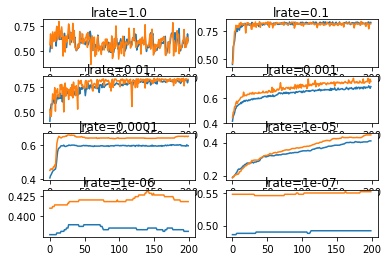

In [9]:
# fit a model and plot the learning rate curve.
def fit_model(trainX, trainy, testX, testy, lrate):
    # define model
    model = Sequential()
    # input layer
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    # output layer, 3 classes
    model.add(Dense(3, activation='softmax'))
    # compile model
    opt = keras.optimizers.SGD(lr=lrate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
    
    # plot learning rate
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('lrate='+str(lrate), pad=-50)
    
trainX, trainy, testX, testy = prepare_data()
learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
for i in range(len(learning_rates)):
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    fit_model(trainX, trainy, testX, testy, learning_rates[i])
    
plt.show()

- we see the model is good performance at learning rate = 0.1 for training and test data 
## 4. Momentum Dynamics
Momentum can smooth the progression of the learning algorithm, that can accelerate the training process.

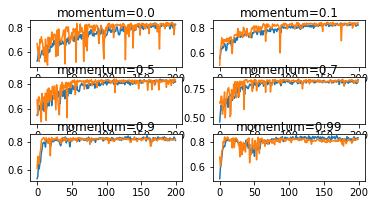

In [17]:
def fit_model_momentum(trainX, trainy, testX, testy, momentum):
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    
    #compile model
    opt = keras.optimizers.SGD(lr=0.01, momentum=momentum)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
    # plot learning curve
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('momentum='+str(momentum), pad=-80)
    
# test datasets
trainX, trainy, testX, testy = prepare_data()
momentums = [0.0, 0.1, 0.5, 0.7, 0.9, 0.99]
for i in range(len(momentums)):
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    fit_model_momentum(trainX, trainy, testX, testy, momentums[i])
    
plt.show()

- We can see that the addition of momentum does accelerate the training of the model. Specifically, momentum values of 0.9 and 0.99 achieve reasonable train and test accuracy within about 50 training epochs as opposed to 200 training epochs when momentum is not used.

- In all cases where momentum is used, the accuracy of the model on the holdout test dataset appears to be more stable, showing less volatility over the training epochs.
## 5. Effect of learning rate schedules
## 5.1 Learning Rate Decay
- The Decay argument is updated the learning rate over multiple updates each epochs. 

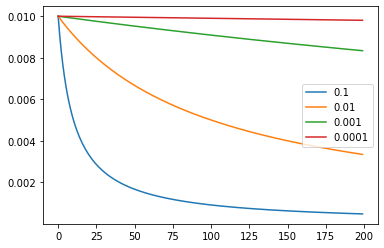

In [20]:
def decay_lrate(initial_lrate, decay, iteration):
    return initial_lrate * (1.0/(1.0 + decay * iteration))

decays = [1e-1, 1e-2, 1e-3, 1e-4]
lrate = 0.01
n_updates = 200
for decay in decays:
    # compute learning rate
    lrates = [decay_lrate(lrate, decay, i) for i in range(n_updates)]
    # plot result
    plt.plot(lrates, label=str(decay))
    
plt.legend()
plt.show()

- We can see that in all cases, the learning rate starts at the initial value of 0.01. We can see that a small decay value of 1E-4 (red) has almost no effect, whereas a large decay value of 1E-1 (blue) has a dramatic effect, reducing the learning rate to below 0.002 within 50 epochs (about one order of magnitude less than the initial value) and arriving at the final value of about 0.0004 (about two orders of magnitude less than the initial value).

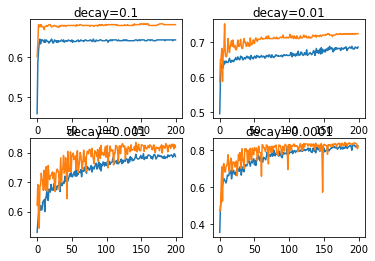

In [11]:
# learning rate decay 
def fit_model_lrdecay(trainX, trainy, testX, testy, decay):
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    opt = keras.optimizers.SGD(lr=0.01, decay=decay)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('decay='+str(decay), pad=-80)
    
trainX, trainy, testX, testy = prepare_data()

decay_rates = [1e-1, 1e-2, 1e-3, 1e-4]
for i in range(len(decay_rates)):
    plot_no = 220 + (i+1)
    plt.subplot(plot_no)
    fit_model_lrdecay(trainX, trainy, testX, testy, decay_rates[i])
    
plt.show()

- We can see that the large decay values of 1E-1 and 1E-2 indeed decay the learning rate too rapidly for this model on this problem and result in poor performance. The smaller decay values do result in better performance, with the value of 1E-4 perhaps causing in a similar result as not using decay at all. In fact, we can calculate the final learning rate with a decay of 1E-4 to be about 0.0075, only a little bit smaller than the initial value of 0.01.
## 5.2 Drop Learning Rate on Plateau
- The ReduceLROnPlateau will drop the learning rate by a factor after no change in a monitored metric for a given number of epochs.

- We can explore the effect of different “patience” values, which is the number of epochs to wait for a change before dropping the learning rate. We will use the default learning rate of 0.01 and drop the learning rate by an order of magnitude by setting the “factor” argument to 0.1.
- We can create a custom Callback called LearningRateMonitor. The on_train_begin() function is called at the start of training, and in it we can define an empty list of learning rates. The on_epoch_end() function is called at the end of each training epoch and in it we can retrieve the optimizer and the current learning rate from the optimizer and store it in the list. 

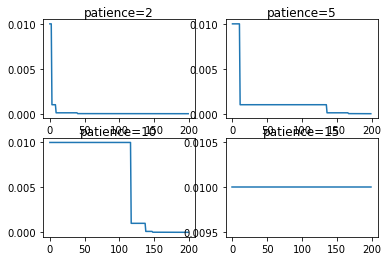

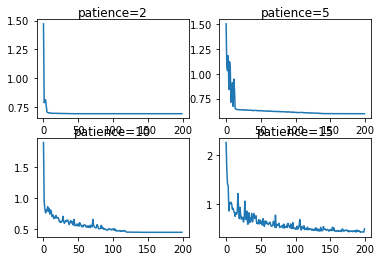

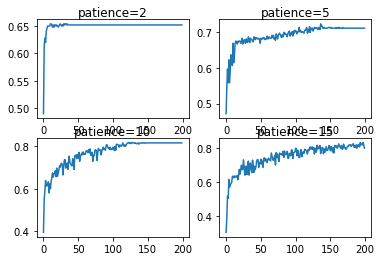

In [5]:
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras import backend


# monitor the learning rate
class LearningRateMonitor(Callback):
    # start training
    def on_train_begin(self, logs={}):
        self.lrates = list()
        
    # end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        #get and store the learning rate
        optimizer = self.model.optimizer
        lrate = float(backend.get_value(self.model.optimizer.lr))
        self.lrates.append(lrate)
        
# train model and plot learning curve
def fit_model(trainX, trainy, testX, testy, patience):
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    
    opt= keras.optimizers.SGD(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # fit model and apply learning rate monitor
    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, min_delta=1e-7)
    lrm = LearningRateMonitor()
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0, callbacks=[rlrp, lrm])

    return lrm.lrates, history.history['loss'], history.history['accuracy']

# plot line for a series
def line_plots(patiences, series):
    for i in range(len(patiences)):
        plt.subplot(220 + (i+1))
        plt.plot(series[i])
        plt.title('patience='+str(patiences[i]), pad=-80)
    plt.show()
    

trainX, trainy, testX, testy = prepare_data()
#create different patiences
patiences = [2, 5, 10, 15]
lr_list, loss_list, acc_list = list(), list(), list()

for i in range(len(patiences)):
    lr, loss, acc = fit_model(trainX, trainy, testX, testy, patiences[i])
    lr_list.append(lr)
    loss_list.append(loss)
    acc_list.append(acc)
    
# plot 
line_plots(patiences, lr_list)
line_plots(patiences, loss_list)
line_plots(patiences, acc_list)

#### Learning rate
- From these plots, we would expect the patience values of 5 and 10 for this model on this problem to result in better performance as they allow the larger learning rate to be used for some time before dropping the rate to refine the weights.

#### Loss
- The plot shows that the patience values of 2 and 5 result in a rapid convergence of the model, perhaps to a sub-optimal loss value. In the case of a patience level of 10 and 15, loss drops reasonably until the learning rate is dropped below a level that large changes to the loss can be seen. This occurs halfway for the patience of 10 and nearly the end of the run for patience 15.

#### Accuracy
- We can see that indeed the small patience values of 2 and 5 epochs results in premature convergence of the model to a less-than-optimal model at around 65% and less than 75% accuracy respectively. The larger patience values result in better performing models, with the patience of 10 showing convergence just before 150 epochs, whereas the patience 15 continues to show the effects of a volatile accuracy given the nearly completely unchanged learning rate.

## 6. Effect of Adaptive learning rate
Keras provides a number of different popular variations of stochastic gradient descent with adaptive learning rates, such as:

- Adaptive Gradient Algorithm (AdaGrad).
- Root Mean Square Propagation (RMSprop).
- Adaptive Moment Estimation (Adam).

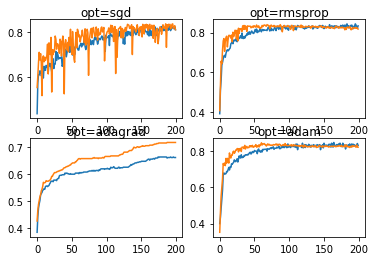

In [6]:
def fit_model(trainX, trainy, testX, testy, optimizer):
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
    # plot 
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('opt='+optimizer, pad=-80)
    
trainX, trainy, testX, testy = prepare_data()
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adam']
for i in range(len(optimizers)):
    plt.subplot(220 + (i+1))
    fit_model(trainX, trainy, testX, testy, optimizers[i])
    
plt.show()

- Again, we can see that SGD with a default learning rate of 0.01 and no momentum does learn the problem, but requires nearly all 200 epochs and results in volatile accuracy on the training data and much more so on the test dataset. The plots show that all three adaptive learning rate methods learning the problem faster and with dramatically less volatility in train and test set accuracy.

- Both RMSProp and Adam demonstrate similar performance, effectively learning the problem within 50 training epochs and spending the remaining training time making very minor weight updates, but not converging as we saw with the learning rate schedules in the previous section.

In [8]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution() # disable eager in TF2
# build the graph for session
hello = tf.constant('Hello, TensorFlow!')
sess = tf.compat.v1.Session()
print(sess.run(hello))
sess.close()

b'Hello, TensorFlow!'


In [10]:
# check if tensorflow working

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub Version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.7.0
Eager mode:  False
Hub Version:  0.12.0
GPU is NOT AVAILABLE
